<a href="https://colab.research.google.com/github/carloslme/tv_program_info/blob/main/personicore_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Exploring the data

In [66]:
base_dir = '/content/drive/My Drive/Colab Notebooks/imagenes'

In [67]:
list_grid = glob.glob(base_dir+'/grid/*.*')
list_show = glob.glob(base_dir+'/show/*.*')
print(len(list_grid))
print(len(list_show))

500
500


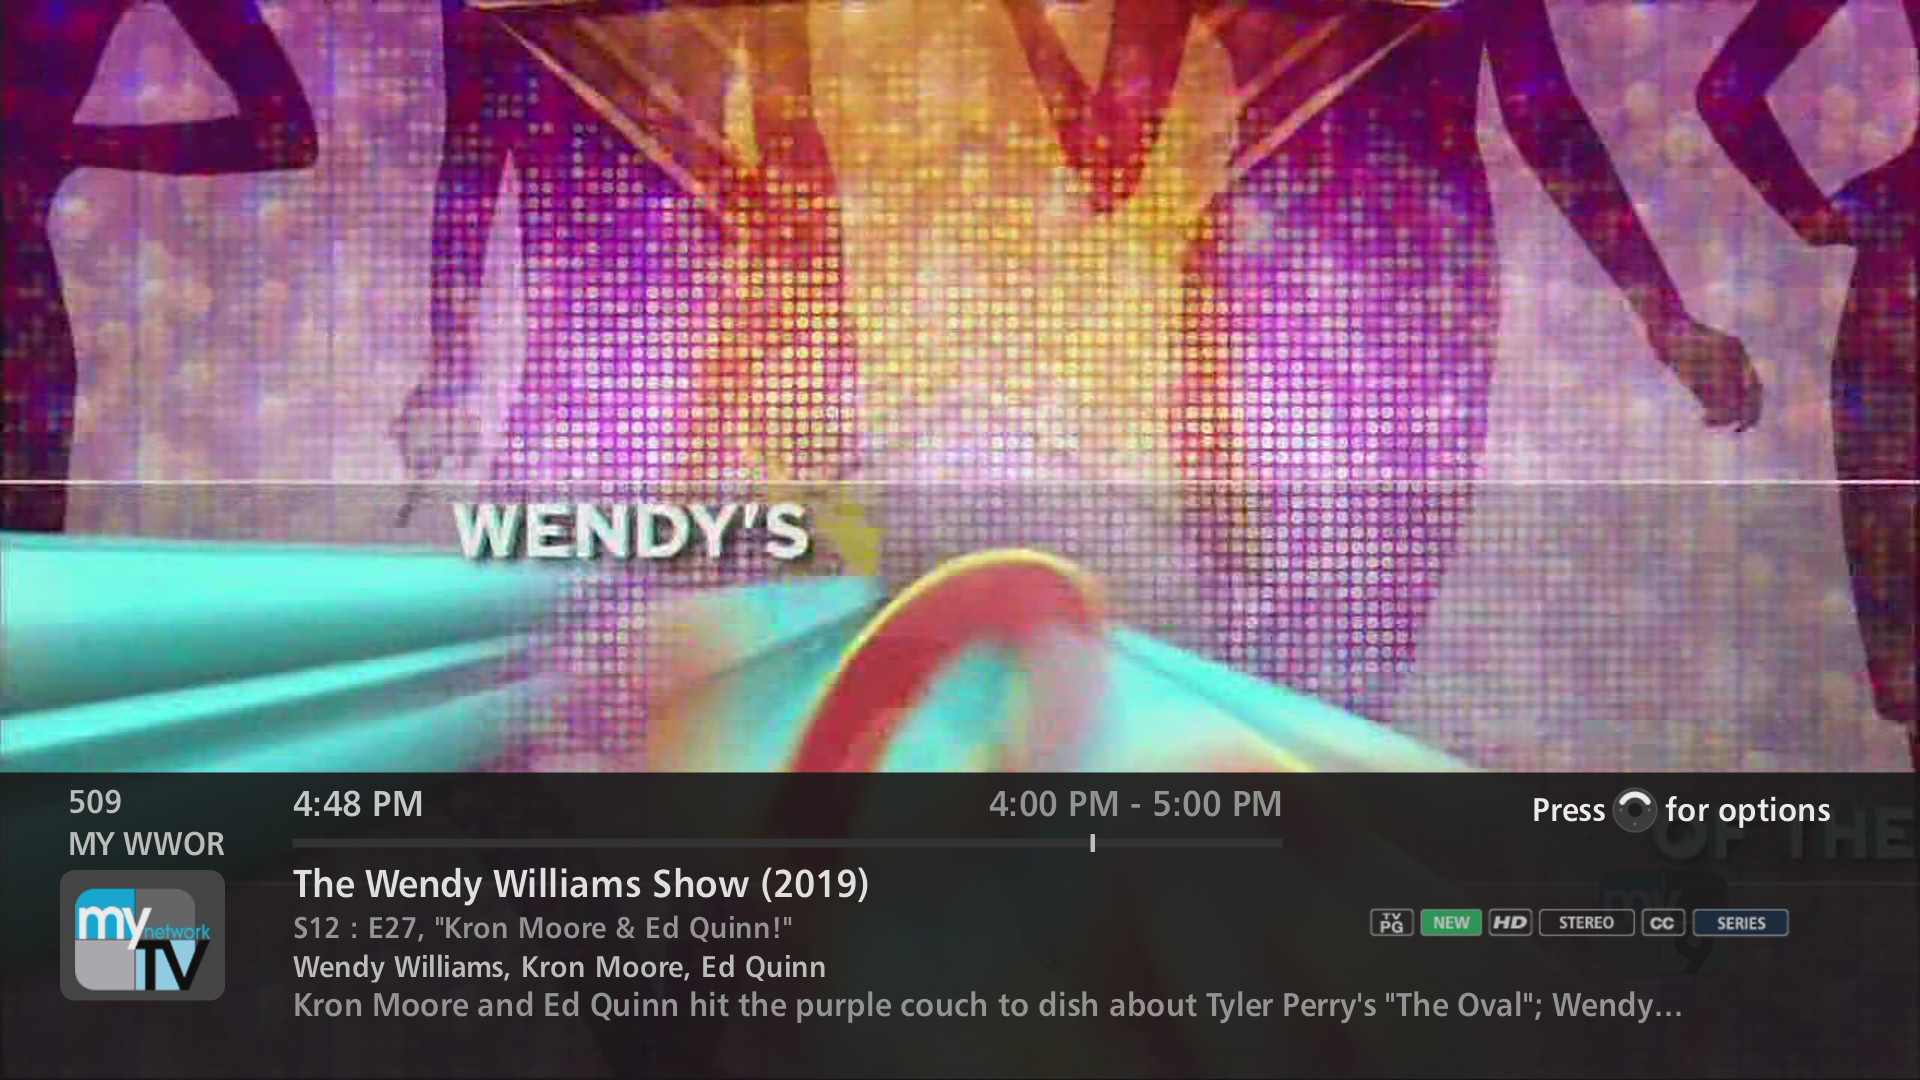

In [4]:
PIL.Image.open(str(list_grid[0]))

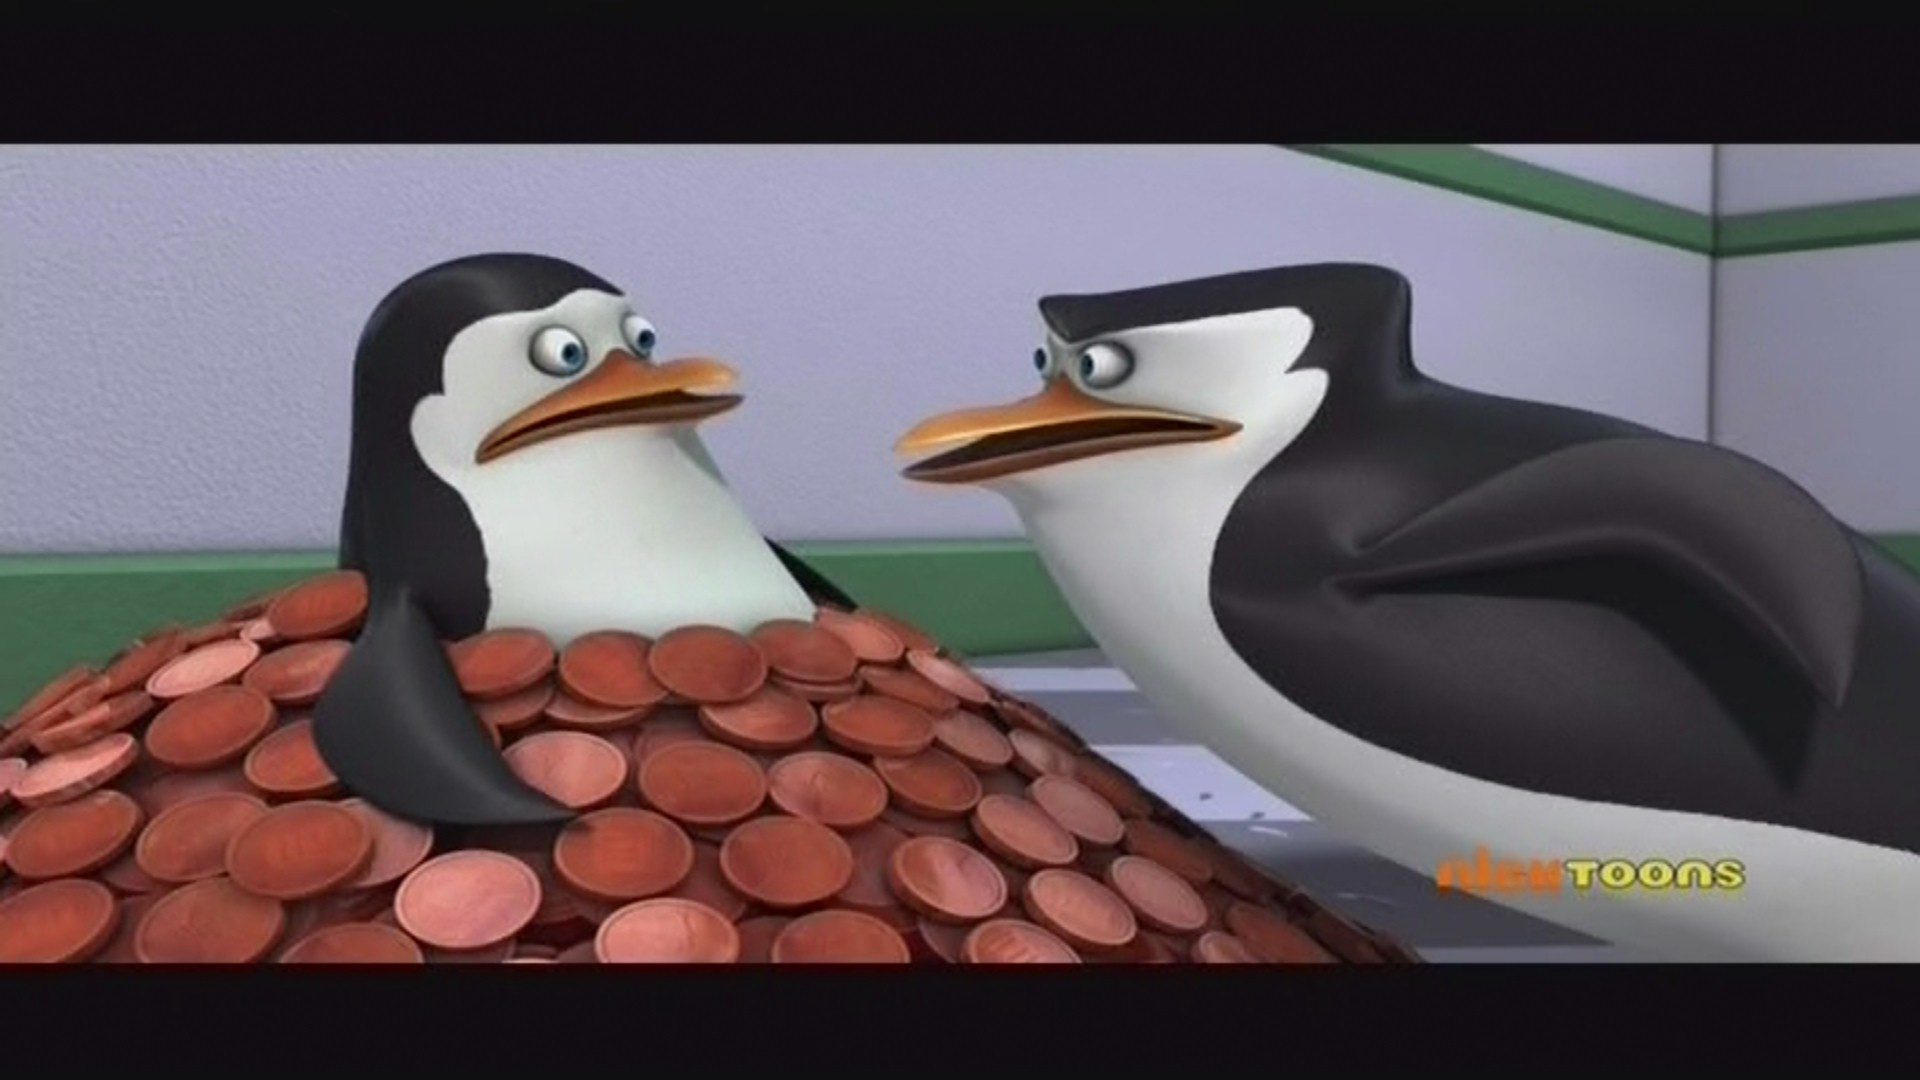

In [5]:
PIL.Image.open(str(list_show[1]))

In [6]:
img_temp = PIL.Image.open(str(list_show[1]))
np.asarray(img_temp).shape

(1080, 1920, 3)

# Load using keras.preprocessing

In [75]:
batch_size = 32
img_height = 256
img_width = 256

In [78]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


In [79]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


In [80]:
class_names = train_ds.class_names
print(class_names)

['grid', 'show']


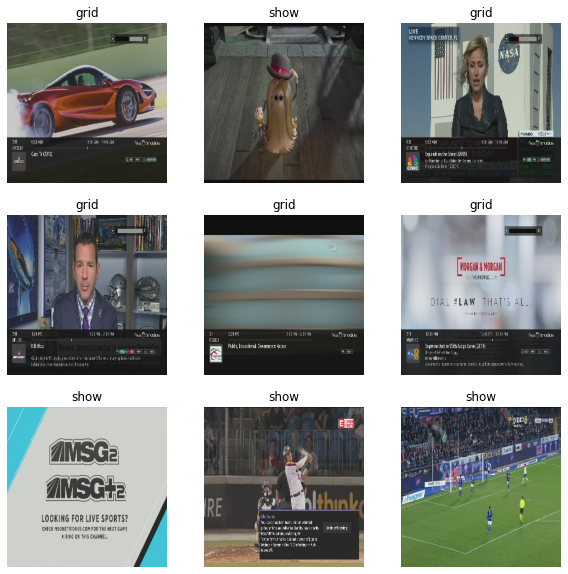

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [82]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [87]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.00041360297 0.9983457


In [88]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)       

In [91]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
25/25 [==============================] - 50s 2s/step - loss: 0.4329 - accuracy: 0.8737 - val_loss: 5.1927e-04 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 47s 2s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9950
Epoch 3/10
25/25 [==============================] - 48s 2s/step - loss: 8.0794e-04 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9950
Epoch 4/10
25/25 [==============================] - 48s 2s/step - loss: 6.1926e-04 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9950
Epoch 5/10
25/25 [==============================] - 47s 2s/step - loss: 6.8935e-06 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 47s 2s/step - loss: 4.3407e-06 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 47s 2s/step - loss: 3.6544e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0

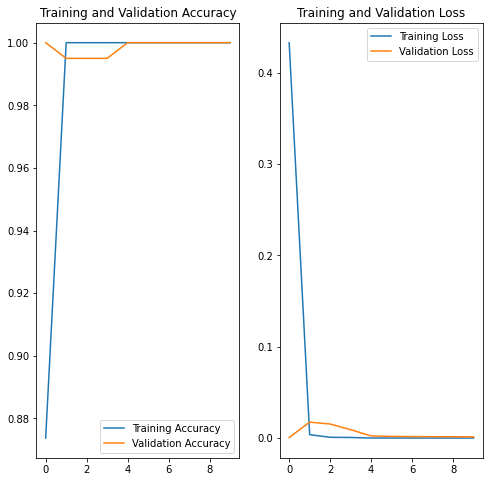

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [93]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

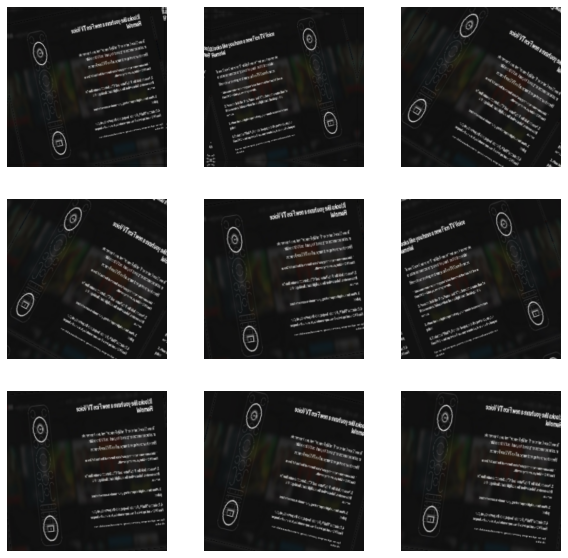

In [94]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [95]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)       

In [98]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
25/25 [==============================] - 57s 2s/step - loss: 0.8899 - accuracy: 0.6800 - val_loss: 0.3452 - val_accuracy: 0.8050
Epoch 2/15
25/25 [==============================] - 57s 2s/step - loss: 0.2541 - accuracy: 0.9025 - val_loss: 0.1724 - val_accuracy: 0.9300
Epoch 3/15
25/25 [==============================] - 56s 2s/step - loss: 0.1148 - accuracy: 0.9563 - val_loss: 0.0432 - val_accuracy: 0.9800
Epoch 4/15
25/25 [==============================] - 57s 2s/step - loss: 0.0578 - accuracy: 0.9825 - val_loss: 0.1882 - val_accuracy: 0.9400
Epoch 5/15
25/25 [==============================] - 57s 2s/step - loss: 0.0385 - accuracy: 0.9887 - val_loss: 0.1252 - val_accuracy: 0.9500
Epoch 6/15
25/25 [==============================] - 57s 2s/step - loss: 0.0301 - accuracy: 0.9925 - val_loss: 0.1258 - val_accuracy: 0.9650
Epoch 7/15
25/25 [==============================] - 58s 2s/step - loss: 0.0259 - accuracy: 0.9950 - val_loss: 0.0303 - val_accuracy: 0.9800
Epoch 8/15
25/25 [==

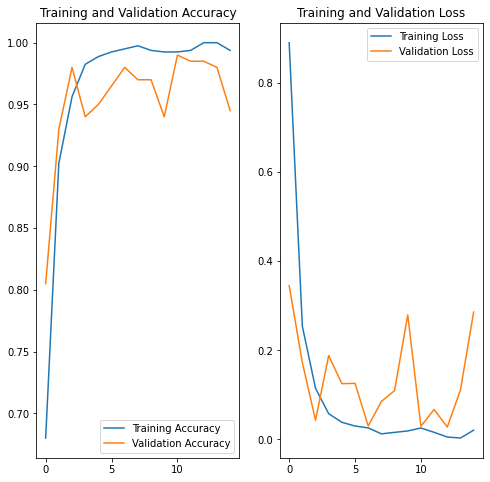

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format


In [100]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_2
model.save('saved_model_2/my_model') 

INFO:tensorflow:Assets written to: saved_model_2/my_model/assets


In [101]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model_2/my_model

my_model
assets	saved_model.pb	variables


In [102]:
new_model = tf.keras.models.load_model('saved_model_2/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)       

In [103]:
!zip -r /content/file_2.zip /content/saved_model_2

  adding: content/saved_model_2/ (stored 0%)
  adding: content/saved_model_2/my_model/ (stored 0%)
  adding: content/saved_model_2/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model_2/my_model/variables/ (stored 0%)
  adding: content/saved_model_2/my_model/variables/variables.index (deflated 66%)
  adding: content/saved_model_2/my_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: content/saved_model_2/my_model/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/file_2.zip")